In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from scipy import stats
import re
import yaml

from typing import Optional
import warnings

warnings.filterwarnings("ignore")
sns.set()
sns.set_palette(palette='rocket') 

# Описание и импорт данных

Задачей данного проекта является предсказание кассовых сборов фильмов.
Данные были собраны с сайта Кинопоиск с использованием собственного парсера. Были выбраны данные о фильмах США за все годы с первых 1000 страниц сайта (на следующих страницах информации о кассовых сборах практически не было).

Проект был разделен на несколько частей, каждая из которых представляет собой отдельный Jupyter ноутбук:
1. **EDA – исследовательский анализ данных, который включает в себя первичный анализ данных, обработку пропусков, преобразование признаков выявление закономерностей и взаимосвязей в данных, формулировка гипотез и визуализация наиболее важных признаков (данный EDA является упрощенной версией исследовательского проекта - ссылка)**
2. Baseline – обучение baseline модели и оценка ее метрик
3. Tuning – подбор гиперпараметров модели для улучшения качества предсказаний и оценка полученных метрик

**Описания полей:**
- title - название фильма
- rating - пользовательский рейтинг на Кинопоиске
- production_year - год производства
- genre - жанр
- director - режиссер
- age_rating - возрастной рейтинг
- release_date - дата релиза
- duration - продолжительность
- cast - актеры
- budget - бюджет
- box_office_usa - кассовые сборы в США
- box_office_world - кассовые сборы по всему миру

target: общий кассовый сбор (США + мир)

In [2]:
config_path = '../config/config.yaml'
config = yaml.load(open(config_path, encoding='utf-8'), Loader=yaml.FullLoader)

config_preproc = config['preprocessing']
RAND = config_preproc['random_state']

In [4]:
df = pd.read_csv(config_preproc['data_path'])

In [5]:
df.head()

,title,rating,production_year,genre,director,age_rating,release_date,duration,cast,budget,box_office_usa,box_office_world
0,Джентльмены (2019),8.6,2019,"криминал, комедия, боевик",Гай Ричи,18+,3 декабря 2019,1 ч 53 мин,"['Мэттью Макконахи', 'Чарли Ханнэм', 'Генри Го...",$22 000 000,$36 471 795,+ $78 700 000
1,Волк с Уолл-стрит (2013),8.0,2013,"драма, криминал, биография, комедия",Мартин Скорсезе,18+,9 декабря 2013,3 ч,"['Леонардо ДиКаприо', 'Джона Хилл', 'Марго Роб...",$100 000 000,$116 900 694,+ $275 100 000
2,Один дома (1990),8.3,1990,"комедия, семейный",Крис Коламбус,0+,10 ноября 1990,1 ч 43 мин,"['Маколей Калкин', 'Джо Пеши', 'Дэниел Стерн',...",$18 000 000,$285 761 243,+ $190 923 432
3,Достать ножи (2019),8.1,2019,"детектив, комедия, драма, криминал",Райан Джонсон,18+,7 сентября 2019,2 ч 10 мин,"['Дэниэл Крэйг', 'Ана де Армас', 'Крис Эванс',...",$40 000 000,$165 363 234,+ $147 534 686
4,Зеленая книга (2018),8.5,2018,"биография, комедия, драма",Питер Фаррелли,18+,11 сентября 2018,2 ч 10 мин,"['Вигго Мортенсен', 'Махершала Али', 'Линда Ка...",$23 000 000,$85 080 171,+ $236 672 485


# EDA

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             50000 non-null  object
 1   rating            49951 non-null  object
 2   production_year   50000 non-null  object
 3   genre             50000 non-null  object
 4   director          50000 non-null  object
 5   age_rating        17323 non-null  object
 6   release_date      46336 non-null  object
 7   duration          50000 non-null  object
 8   cast              50000 non-null  object
 9   budget            11997 non-null  object
 10  box_office_usa    10610 non-null  object
 11  box_office_world  5590 non-null   object
dtypes: object(12)
memory usage: 4.6+ MB


## target, box_office_usa, box_office_world

- для начала создадим таргет переменную - сумма кассовых сборов в США и во всем мире
- target = box_office_usa + box_office_world
- но кассовые сборы представлены типом object и содержат в себе знак $, поэтому для начала уберем его 

In [7]:
def remove_symbols(obj: str) -> str:
    '''
    Убирает ненужные символы и пробелы из строки, оставляя цифры
    
    Parameters
    ---------
    obj: str
        входящая строка 
        
    Returns
    ---------
    Строка только с цифрами
    '''
    return ''.join(re.findall(r'[\d]', str(obj)))

In [8]:
# список с нужными нам столбцами
box_office_cols = ['box_office_usa', 'box_office_world']

# вызов функции для удаления знака $ из строки
for col in box_office_cols:
    df[col] = df[col].apply(lambda x: remove_symbols(x))

- после применения функции пропущенные значения изменили свой тип на string, поэтому найдем их и заменим на None

In [9]:
def replace_values_with_none(obj: str, value: str) -> Optional[str]:
    '''
    Parameters
    -----------
    obj: str
        входящая строка
    value: str
        значение, которое нужно заменить на None
    
    Returns
    ----------
    Входящая строка либо None
    '''
    return None if obj == value else obj

In [10]:
# вызов функции для замены значения 'nan' на None
for col in box_office_cols:
    df[col] = df[col].apply(lambda x: replace_values_with_none(x, ''))

In [11]:
def add_target_variable(box_off_usa: Optional[int],
                        box_off_world: Optional[int]) -> Optional[int]:
    '''
    Создает таргет переменную (общие кассовые сборы)
    
    Parameters
    ---------
    box_off_usa: Optional[int]
        кассовые сборы в США
    box_off_world: Optional[int]
        кассовые сборы по миру
    
    Returns
    ---------
    общие кассовые сборы / None
    '''
    if box_off_usa and box_off_world:
        return int(box_off_usa) + int(box_off_world)
    elif box_off_usa:
        return int(box_off_usa)
    elif box_off_world:
        return int(box_off_world)
    else:
        return None

In [12]:
# создание таргет переменной
df['target'] = df.apply(
    lambda x: add_target_variable(x['box_office_usa'], x['box_office_world']),
    axis=1)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             50000 non-null  object 
 1   rating            49951 non-null  object 
 2   production_year   50000 non-null  object 
 3   genre             50000 non-null  object 
 4   director          50000 non-null  object 
 5   age_rating        17323 non-null  object 
 6   release_date      46336 non-null  object 
 7   duration          50000 non-null  object 
 8   cast              50000 non-null  object 
 9   budget            11997 non-null  object 
 10  box_office_usa    10610 non-null  object 
 11  box_office_world  5590 non-null   object 
 12  target            11642 non-null  float64
dtypes: float64(1), object(12)
memory usage: 5.0+ MB


- в таргет переменной всего лишь 11642 ненулевых значения 
- данных о кассовых сборах может не быть, если фильм не показывали в кинотеатрых либо если кассовых сборов практически не было
- **<span style="color:red">так как проект учебный, было решено удалить пропущенные значения и работать с теми, что останутся</span>**

In [14]:
# удаление пропущенных значений в таргет переменной
df = df.dropna(subset=['target'])

- проверим распределение таргет переменной на нормальность

In [15]:
def check_distribution(column: pd.Series) -> None:
    '''
    Проверяет распределние в столбце на нормальность с помощью критерия Шапиро-Уилка
    
    Parameters
    -----------
    column: pd.Series
        столбец для проверки распределния
    Returns 
    -----------
    None - просто текст с результатом
    '''
    shapiro = stats.shapiro(column)
    if shapiro.pvalue >= 0.05:
        print(f'P-value = {shapiro.pvalue} - распределение нормальное')
    else:
        print(f'P-value = {shapiro.pvalue} - распределение не нормальное')

In [16]:
# проверка рапределения таргет переменной
check_distribution(df.target)

P-value = 0.0 - распределение не нормальное


In [17]:
def plot_distribution(data: pd.Series, col_name: str) -> None:
    '''
    Строит график распределения величины
    
    Parameters
    ----------
    data: pd.Series
        данные для построения графика
    col_name: str
        название столбца, для которого строится график
    
    Returns
    ----------
    None (строит график)
    '''
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.kdeplot(data, fill=True)
    ax.set_title(f'Распределение значений {col_name}', fontsize=16)
    ax.set_xlabel(f'{col_name}', fontsize=14)
    ax.set_ylabel('density', fontsize=14)

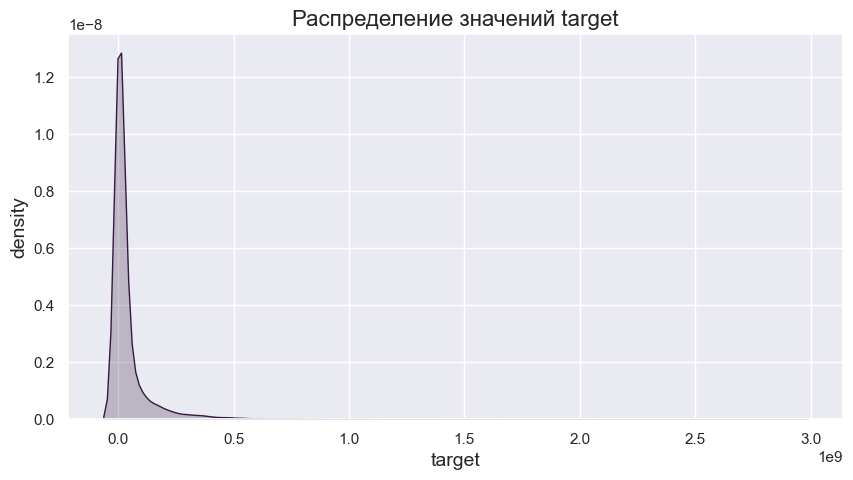

In [18]:
plot_distribution(df.target, 'target')

- распределение смещено в одну сторону и далеко от нормального
- прологарифмируем таргет переменную и проверим полученное распределение на нормальность  

In [19]:
# логарифмирование таргет переменной
df['target_log'] = np.log(df.target)

In [20]:
# проверка рапределения прологарифмированной таргет переменной
check_distribution(df.target_log)

P-value = 4.764414778704378e-44 - распределение не нормальное


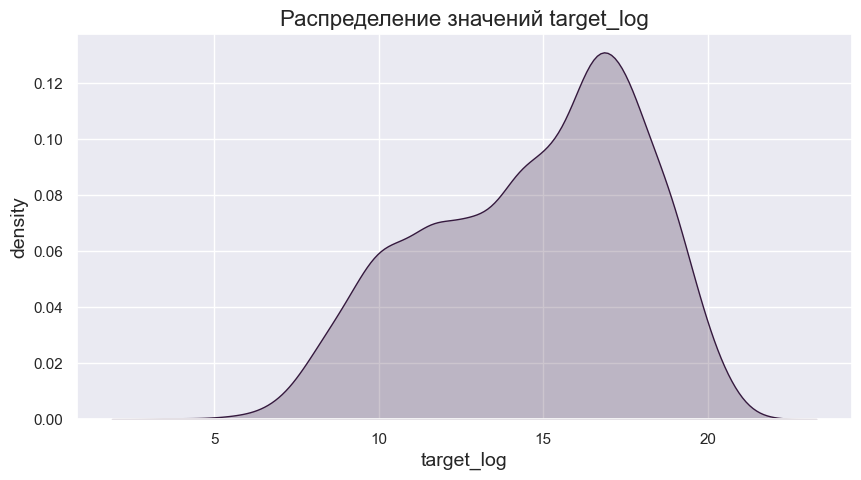

In [21]:
plot_distribution(df.target_log, 'target_log')

- распределение все еще далеко от нормального, но уже выглядит лучше 
- нас устраивает такая ситуация - дальше будем просто использовать функцию потерь, которая устойчива к выбросам

In [22]:
df.isna().sum()

title                  0
rating                 4
production_year        0
genre                  0
director               0
age_rating          3450
release_date          23
duration               0
cast                   0
budget              5127
box_office_usa      1032
box_office_world    6052
target                 0
target_log             0
dtype: int64

- в столбцах box_office_usa и box_office_world все еще остались пропущенные значения - заполним их нулями
- будем считать, что если нет никакой информации о сборах по миру, но фильм показывали только в США, а если нет информации о сборах в США - фильм создавали для показа в других странах

In [23]:
# заполнение пропущенных значений нулями
df[box_office_cols] = df[box_office_cols].fillna(0)

In [24]:
# изменим тип данных на float
df[box_office_cols] = df[box_office_cols].astype(float)

## production_year

- по какой-то причине в production_year присутсвуют разные слова, заменим их на None

In [25]:
df.production_year.value_counts()

2014          342
2013          341
2006          339
2008          338
2015          338
             ... 
Монтаж          1
Режиссер        1
Художник        1
Композитор      1
1919            1
Name: production_year, Length: 117, dtype: int64

In [26]:
# замена разных слов на None
df.production_year = df.production_year.apply(lambda x: x if x.isdigit() else None)

- будем считать, что год производства совпадает с годом релиза, и заполним пропущенные значения 

In [27]:
def fill_production_year(prod_year: Optional[str],
                         release_date: Optional[str]) -> str:
    '''
    Заполняет пропущенные значения в столбце с годом производства годом релиза
    
    Parameters
    --------
    prod_year: Optional[str]
        год производства фильма
    release_date: Optional[str]
        дата релиза фильма
    
    Returns
    --------
    год релиза
    '''
    if not prod_year and release_date:
        return release_date.split(' ')[-1]
    return prod_year

In [28]:
# применение функции для заполнения пропущенных значений
df.production_year = df.apply(
    lambda x: fill_production_year(x['production_year'], x['release_date']),
    axis=1)

- изменим тип данных года производства на int

In [29]:
# изменение типа данных на int
df.production_year = df.production_year.astype(int)

## duration

- переведем duration в минуты

In [30]:
def convert_duration(duration: str) -> int:
    '''
    Переводит продолжительность фильма в нужную нам форму (только минуты)
    
    Parameters
    -----------
    duration: str
        длительность фильма
    
    Returns
    ---------
    Продолжительность фильма в минутах
    '''
    hours, minutes = 0, 0

    search_hours = re.search(r'(\d+)\s*ч', duration)
    search_minutes = re.search(r'(\d+)\s*мин', duration)

    if search_hours:
        hours = int(search_hours.group(1))

    if search_minutes:
        minutes = int(search_minutes.group(1))

    return hours * 60 + minutes

In [31]:
# применение функции для перевода продолжительности в минуты
df.duration = df.duration.apply(lambda x: convert_duration(x))

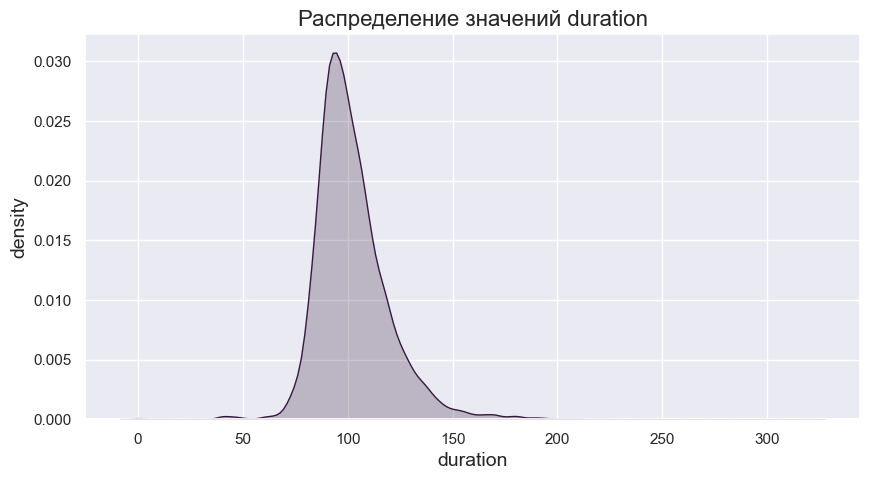

In [32]:
plot_distribution(df.duration, 'duration')

- как видим, наиболее частая продолжительность фильма равна примерно 90 минутам

## genre

- жанр представлен строкой, содержащей названия
- преобразуем строку в список жанров

In [33]:
df.genre.value_counts()

драма                                                           751
комедия                                                         515
драма, мелодрама, комедия                                       495
драма, комедия                                                  480
мелодрама, комедия                                              412
                                                               ... 
мюзикл, боевик, комедия, криминал, приключения, музыка            1
мультфильм, фэнтези, комедия, приключения, семейный, военный      1
фантастика, боевик, триллер, комедия                              1
триллер, фэнтези, ужасы, детектив                                 1
документальный, короткометражка, спорт                            1
Name: genre, Length: 1835, dtype: int64

In [34]:
# преобразование строки в список
df.genre = df.genre.str.split(', ')

- предположим, что основной жанр фильма стоит на первом месте
- создадим новый столбец с основным жанром фильма

In [35]:
# создание нового столбца - основной жанр
df['main_genre'] = df.genre.apply(lambda x: x[0])

In [36]:
# подсчет значений в столбце с основным жанром
df.main_genre.value_counts()

драма              3583
боевик             1212
ужасы              1148
триллер            1109
комедия            1019
документальный      861
фантастика          695
мелодрама           602
фэнтези             417
мультфильм          382
мюзикл              228
вестерн              77
биография            58
фильм-нуар           51
детектив             49
криминал             43
приключения          39
семейный             22
военный              15
спорт                14
музыка                5
короткометражка       5
история               4
для взрослых          2
аниме                 2
Name: main_genre, dtype: int64

In [37]:
def plot_counts(data: pd.Series, col_name: str) -> None:
    '''
    Строит count plot
    
    Parameters
    ----------
    data: pd.Series
        данные для построения графика
    col_name: str
        название столбца, для которого строится график
    
    Returns
    ----------
    None (строит график)
    '''
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.countplot(data, palette='rocket')
    ax.set_title(f'Подсчет значений {col_name}', fontsize=16)
    ax.set_ylabel(f'{col_name}', fontsize=14)
    ax.set_xlabel('count', fontsize=14)

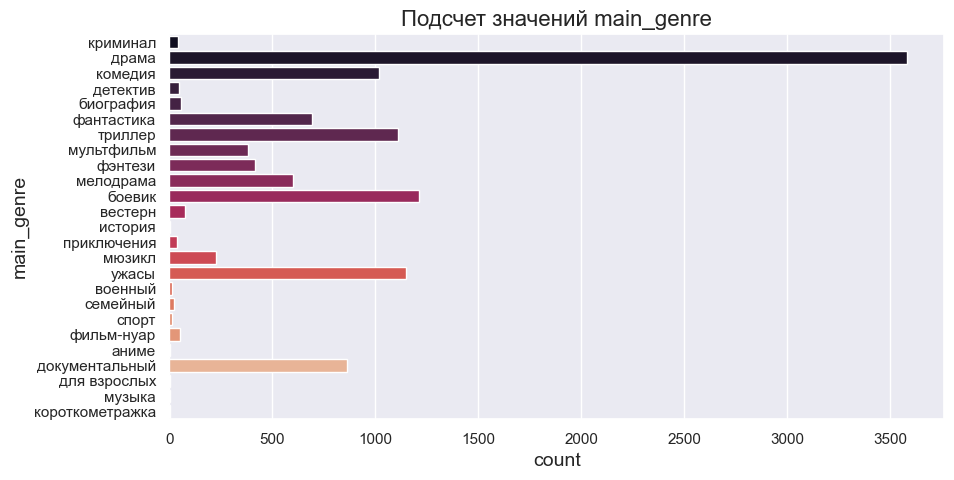

In [38]:
plot_counts(df.main_genre, 'main_genre')

## rating

In [39]:
df.isna().sum()

title                  0
rating                 4
production_year        0
genre                  0
director               0
age_rating          3450
release_date          23
duration               0
cast                   0
budget              5127
box_office_usa         0
box_office_world       0
target                 0
target_log             0
main_genre             0
dtype: int64

- у некоторых фильмов нет рейтинга 
- это может означать то, что фильм еще не вышел
- пропущенных значений очень мало, поэтому можно просто удалить их

In [40]:
# удаление пропущенных значений 
df = df.dropna(subset=['rating'])

- кроме того, есть фильмы, у которых вместо рейтинга стоит прочерк. Это может означать, что у фильма недостаточно рецензий для формирования оценок 
- заменим эти прочерки на среднее значение оценки по основному жанру

In [41]:
# вызов функции для замены прочерков на None
df.rating = df.rating.apply(lambda x: replace_values_with_none(x, "–"))

- поменяем перед этим тип rating на float

In [42]:
# изменение типа данных на float
df.rating = df.rating.astype(float)

In [43]:
# заменяем пропущенные значения на среднее по жанру
df.rating = df.groupby('main_genre').rating.apply(lambda x: x.fillna(x.mean()))

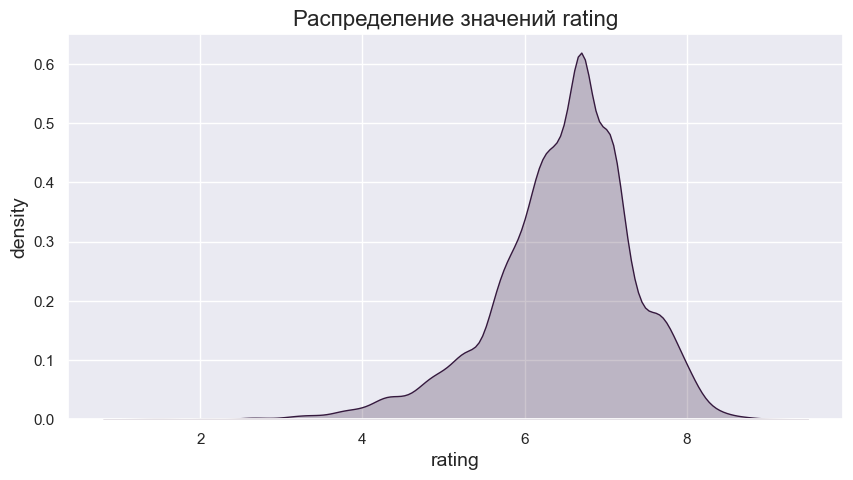

In [44]:
plot_distribution(df.rating, 'rating')

- можно заметить, что самая частая оценка это примерно 6.7

## age_rating

- в столбце age_rating довольно много пропущеных значений

In [45]:
# подсчет значений в столбце с возрастным рейтингом
df.age_rating.value_counts()

18+    4006
16+    1963
12+    1494
0+      414
6+      313
Name: age_rating, dtype: int64

- наиболее частый возрастной рейтинг это 18+, но заменять все значения этой модой не имеет смысла
- поэтому заполним пропущенные значения словом 'undefined'

In [46]:
# заполнение пропусков 
df.age_rating = df.age_rating.fillna('undefined')

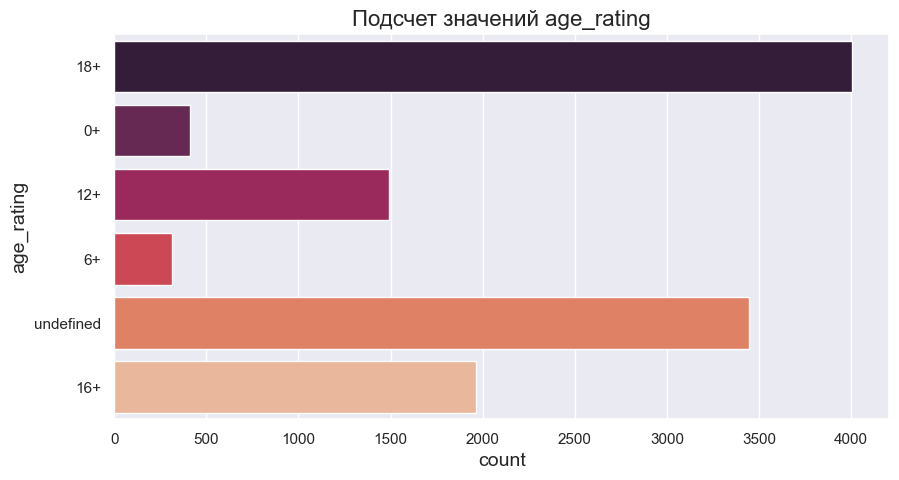

In [47]:
plot_counts(df.age_rating, 'age_rating')

- на графике можно увидеть, что снова самый частый класс это 18+, но undefined тоже довольно много

## release_date

- пропущенных значений в данной столбце очень мало, поэтому можно просто удалить их
- после извлечем месяц из даты релиза

In [48]:
# удаление пропущенных значений
df = df.dropna(subset=['release_date'])

In [49]:
# создание нового столбца
df['month'] = df.release_date.apply(lambda x: x.split(' ')[1])

In [50]:
df.head()

,title,rating,production_year,genre,director,age_rating,release_date,duration,cast,budget,box_office_usa,box_office_world,target,target_log,main_genre,month
0,Джентльмены (2019),8.6,2019,"[криминал, комедия, боевик]",Гай Ричи,18+,3 декабря 2019,113,"['Мэттью Макконахи', 'Чарли Ханнэм', 'Генри Го...",$22 000 000,36471795.0,78700000.0,115171795.0,18.561935,криминал,декабря
1,Волк с Уолл-стрит (2013),8.0,2013,"[драма, криминал, биография, комедия]",Мартин Скорсезе,18+,9 декабря 2013,180,"['Леонардо ДиКаприо', 'Джона Хилл', 'Марго Роб...",$100 000 000,116900694.0,275100000.0,392000694.0,19.786774,драма,декабря
2,Один дома (1990),8.3,1990,"[комедия, семейный]",Крис Коламбус,0+,10 ноября 1990,103,"['Маколей Калкин', 'Джо Пеши', 'Дэниел Стерн',...",$18 000 000,285761243.0,190923432.0,476684675.0,19.982366,комедия,ноября
3,Достать ножи (2019),8.1,2019,"[детектив, комедия, драма, криминал]",Райан Джонсон,18+,7 сентября 2019,130,"['Дэниэл Крэйг', 'Ана де Армас', 'Крис Эванс',...",$40 000 000,165363234.0,147534686.0,312897920.0,19.561388,детектив,сентября
4,Зеленая книга (2018),8.5,2018,"[биография, комедия, драма]",Питер Фаррелли,18+,11 сентября 2018,130,"['Вигго Мортенсен', 'Махершала Али', 'Линда Ка...",$23 000 000,85080171.0,236672485.0,321752656.0,19.589294,биография,сентября


- название месяца написано не в именительном падеже - изменим это

In [51]:
# замена значений
df.month = df.month.map(config_preproc['map_columns']['month_names'])

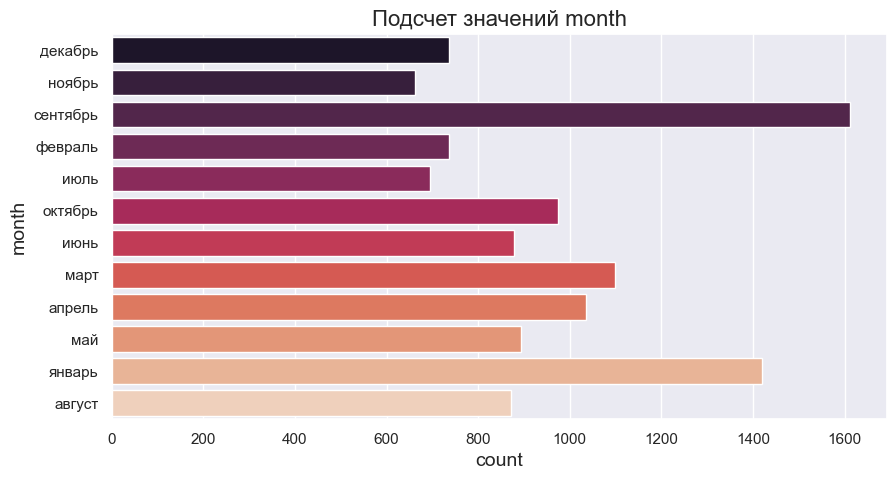

In [52]:
plot_counts(df.month, 'month')

- больше всего фильмов было выпущено с сентябре, январе и марте

## budget

- в столбце с бюджетом очень много пропущенных значений
- сгруппируем по основному жанру и заполним средним
- для начала уберем из бюджета знаки валют 
- так как бюджет был задан только в долларах и евро, не будет конвертировать бюджет в доллары

In [53]:
# удаление знаков валют из бюджета
df.budget = df.budget.apply(lambda x: remove_symbols(x))

- после применения функции пропущенные значения изменили свой тип на string, поэтому найдем их и заменим на None

In [54]:
# вызов функции для замены прочерков на None
df.budget = df.budget.apply(lambda x: replace_values_with_none(x, ''))

- и поменяем тип данных на float

In [55]:
# изменение типа данных на float 
df.budget = df.budget.astype(float)

# заполнение пропусков средним значением по основному жанру
df.budget = df.budget.fillna(
    df.groupby('main_genre').budget.apply(lambda x: x.fillna(x.mean())))

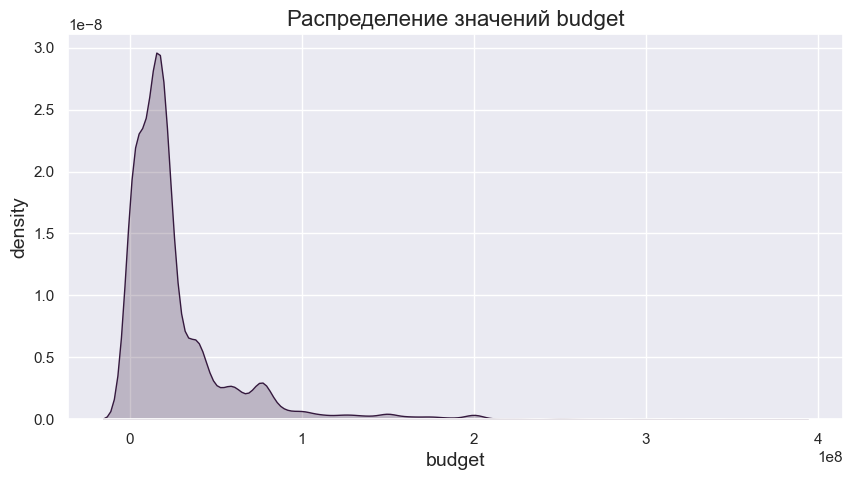

In [56]:
plot_distribution(df.budget, 'budget')

In [57]:
round(df.budget.mean(), 1)

26196012.9

- как видим, средний бюджет фильма равен примерно 26 млн долларов
- но стоит также учитывать то, что в наборе довольно много фильмов, которые являются популярными и высокобюджетными 

## director

- иногда в фильме отсутсвует информация о режиссере и стоит "-", поэтому заменим прочерк на None

In [58]:
# вызов функции для замены прочерков на None
df.director = df.director.apply(lambda x: replace_values_with_none(x, '—'))

In [59]:
df.isna().sum()

title               0
rating              0
production_year     0
genre               0
director            5
age_rating          0
release_date        0
duration            0
cast                0
budget              0
box_office_usa      0
box_office_world    0
target              0
target_log          0
main_genre          0
month               0
dtype: int64

- фильмов, у которых не указан режиссер, всего 5, поэтому можно их просто удалить 

In [60]:
# удаление фильмов без режиссера
df = df.dropna(subset=['director'])

In [61]:
# подсчет значений в столбце
df.director.value_counts()

Вуди Аллен                     42
Клинт Иствуд                   38
Стивен Спилберг                33
Стивен Содерберг               28
Мартин Скорсезе                26
                               ..
Джастин Типпинг                 1
Бонни Хант                      1
Ли Кирк                         1
Алан Майерсон, Джеймс Фарго     1
Чарли Леви                      1
Name: director, Length: 5703, dtype: int64

In [62]:
sum(df.director.value_counts() == 1)

3764

- как видим, в наборе очень много режиссеров, у которых всего 1 фильм

In [63]:
(df.director.value_counts() >= 10).sum()

111

- а режиссеров, у которых минимум 10 фильмов, всего 111

- посмотрим на топ-30 режиссеров

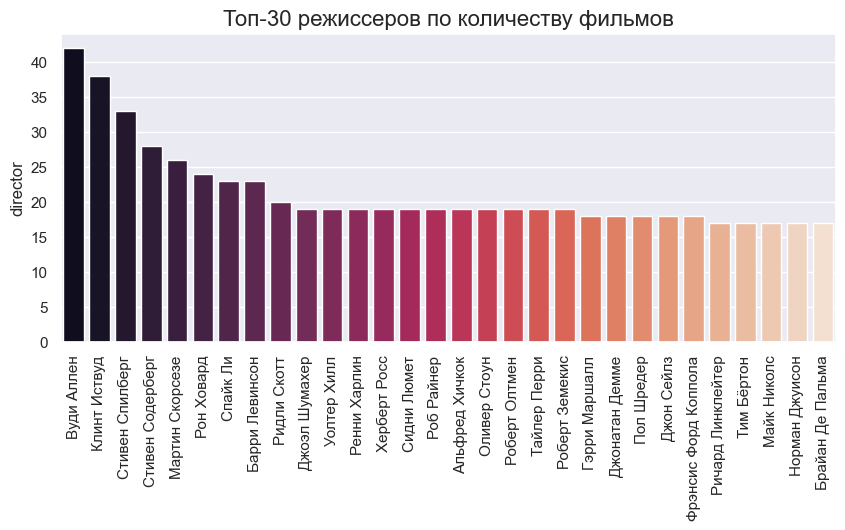

In [64]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(df.director.value_counts()[:30],palette='rocket')
ax.set_title('Топ-30 режиссеров по количеству фильмов', fontsize=16)
plt.xticks(rotation=90);

- создадим столбец, кторый будет показывать количество фильмов у режиссера

In [65]:
# создание нового столбца
df['director_film_count'] = df.groupby('director').title.transform('count')

## cast

- у некоторых фильмов не указан актерский состав, вместо этого стоит пустой список
- заменим этот список на None

In [66]:
# вызов функции для замены пустых списков на None
df.cast = df.cast.apply(lambda x: replace_values_with_none(x, '[]'))

In [67]:
df.isna().sum()

title                   0
rating                  0
production_year         0
genre                   0
director                0
age_rating              0
release_date            0
duration                0
cast                   24
budget                  0
box_office_usa          0
box_office_world        0
target                  0
target_log              0
main_genre              0
month                   0
director_film_count     0
dtype: int64

- как видим, таких значений было всего 24, поэтому можем просто удалить их

In [68]:
# удаление пропущенных значений
df = df.dropna(subset=['cast'])

In [69]:
df.cast.iloc[0]

"['Мэттью Макконахи', 'Чарли Ханнэм', 'Генри Голдинг', 'Хью Грант', 'Мишель Докери', 'Джереми Стронг', 'Эдди Марсан', 'Джейсон Вонг', 'Колин Фаррелл', 'Лин Рене', '75 актеров', 'Роли дублировали', 'Василий Дахненко', 'Сергей Смирнов', 'Филипп Бледный', 'Алексей Иващенко', 'Татьяна Шитова']"

- строка представляет собой список актеров 
- нужно распарсить данную строку, убрать все лишние символы и превратить в список 
- будем считать, что на первых трех местах в списке стоят главные актеры, поэтому оставим только их 

In [70]:
# преобразование строки
df.cast = df.cast.apply(lambda x: ''.join(re.findall(r'[^\'\[\]]', x)).split(', ')[:3])

In [71]:
df.cast.iloc[0]

['Мэттью Макконахи', 'Чарли Ханнэм', 'Генри Голдинг']

- так как нас больше интересуют актеры по отдельности, то разделим их на отдельные строки 

In [72]:
# разделение актеров на строки
all_actors = df.cast.explode()

In [73]:
sum(all_actors.value_counts() >= 10)

695

- как видим, актеров, которые снимались в более чем 10 фильмах, всего 695

- создадим словарь, где ключом будет имя актера, а значением - количество фильмов, в котором он снимался

In [74]:
actor_counts = all_actors.value_counts().to_dict()

- создадим новый столбец 'actors_fame', который будет означать славу всех актеров в фильме - количество фильмов, в которых актеры снимались

In [74]:
def calculate_fame(actors_list: list) -> int:
    '''
    Считает славу для списка актеров
    
    Parameters
    ----------
    actors_list: list
        список с актерами фильма
    
    Returns
    ----------
    значение славы для фильма
    '''
    return sum(actor_counts.get(actor, 0) for actor in actors_list)

In [75]:
# использование функции для создания столбца
df['actors_fame'] = df.cast.apply(lambda x: calculate_fame(x))

# Гипотезы

**Сформулируем гипотезы, которые будут либо напрямую связаны с целевой переменной, либо могут быть довольно важными**
- Фильмы определенных жанров в среднем собирают больше денег
- На кассовые сборы в основном влияют бюджет и рейтинг фильма
- Если фильм собирает много денег в мировом прокате, то обычно он собираем много денег и в США
- Возрастной рейтинг влияет на кассовые сборы
- Более известные режиссеры снимают фильмы, которые приносят в среднем больше денег
- Более новые фильмы приносят больше денег
- Наличие известных актеров положительно влияет на сборы

## Гипотеза 1

**Фильмы определенных жанров в среднем собирают больше денег**

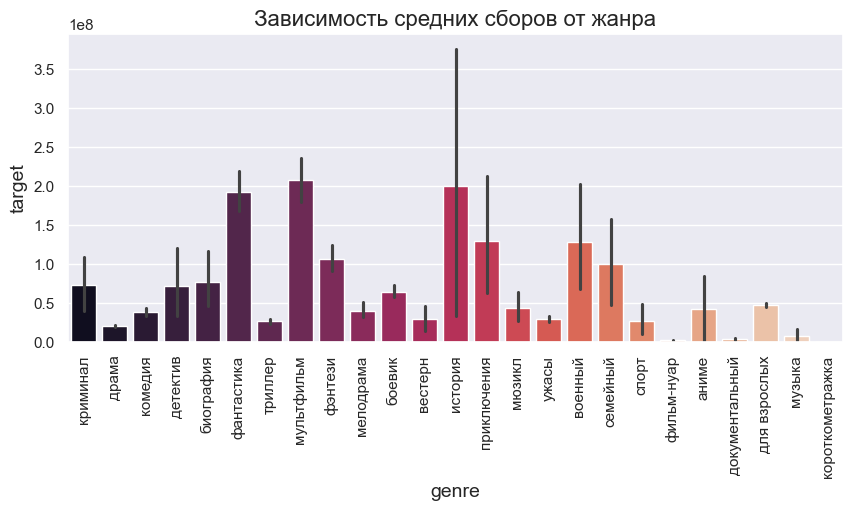

In [76]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(data=df, y='target', x='main_genre', palette='rocket')
ax.set_title('Зависимость средних сборов от жанра', fontsize=16)
ax.set_xlabel('genre', fontsize=14)
ax.set_ylabel('target', fontsize=14)
plt.xticks(rotation=90);

- можно заметить, что в среднем больше всего приносят кассовые собры фильмов с такими жанрами: мультфильм, история и фантастика
- хотя у исторических фильмов, в отличии от остальных жанров, довольно большой разброс значений 
- кроме того, можно выделить несколько жанров, которые в среднем приносят намного меньше денег, чем остальные: фильм-нуар, документальный, музыка и короткометражка. Это может быть связано с тем, что данные жанры больше ориентированы на узкий круг людей
- также можно сказать, что, скорее всего, мультфильмы в среднем приносят больше денег из-за того, что на них обычно ходят всей семьей -> покупают больше билетов
- гипотеза подтвердилась

## Гипотеза 2

**На кассовые сборы в основном влияют бюджет и рейтинг фильма**

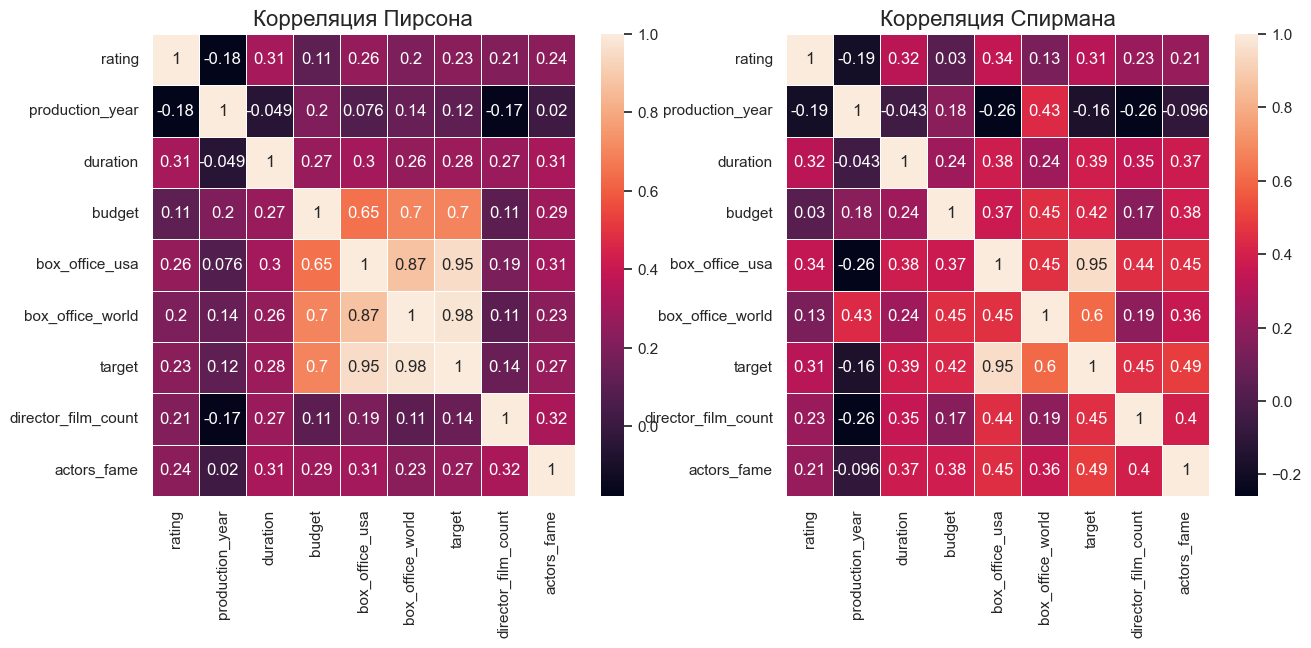

In [77]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 6))
sns.heatmap(df.drop('target_log', axis=1).corr(),
            annot=True,
            linewidths=.7,
            ax=ax[0])
sns.heatmap(df.drop('target_log', axis=1).corr(method='spearman'),
            annot=True,
            linewidths=.7,
            ax=ax[1])
ax[0].set_title('Корреляция Пирсона', fontsize=16)
ax[1].set_title('Корреляция Спирмана', fontsize=16);

- можно заметить, что при обоих видах корреляции рейтинг не так сильно влияет на сборы 
- все же больше влияет бюджет (особенно по корреляции Пирсона, хотя по Пирсону все же связь не такая сильная)
- кроме того, длительность фильма влияет на кассовые сборы даже немного больше, чем рейтинг
- но если анализировать всю тепловую карту, то все же сильных зависимостей нет 
- гипотеза подтвердилась лишь на половину

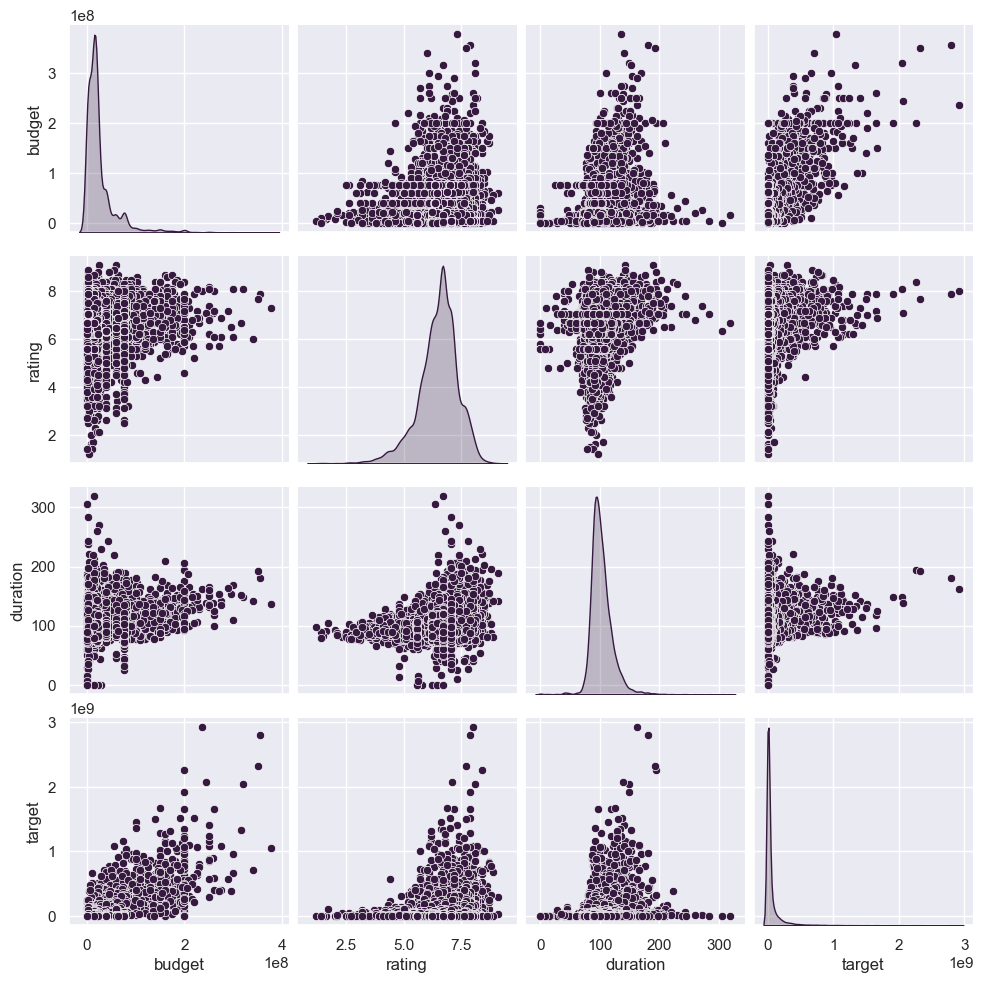

In [78]:
sns.pairplot(df[['budget', 'rating', 'duration', 'target']], diag_kind='kde');

Если рассматривать более подробно pairplot, то можно заметить:
- в какой-то мере кассовые сборы фильма и правда зависят от бюджета - это так же подтверждает построенная выше тепловая карта
- фильмы с большим бюджетом действительно собирают больше денег 
- но для фильмов с меньшим бюджетом это выражено не так сильно и работает не всегда 
- слишком длинные фильмы приносят не очень много денег - примерно столько же, сколько и короткие
- кроме того, больше денег принесли фильмы продолжительностью от 90 до 150 минут 
- это может быть связано с тем, что люди не слишком много времени тратят на просмотр и в то же время сюжет не слишком короткий/затянутый
- фильмы с более высоким рейтингом обычно приносят больше денег, чем фильмы с низким рейтингом

## Гипотеза 3

**Если фильм собирает много денег в мировом прокате, то обычно он собираем много денег и в США**

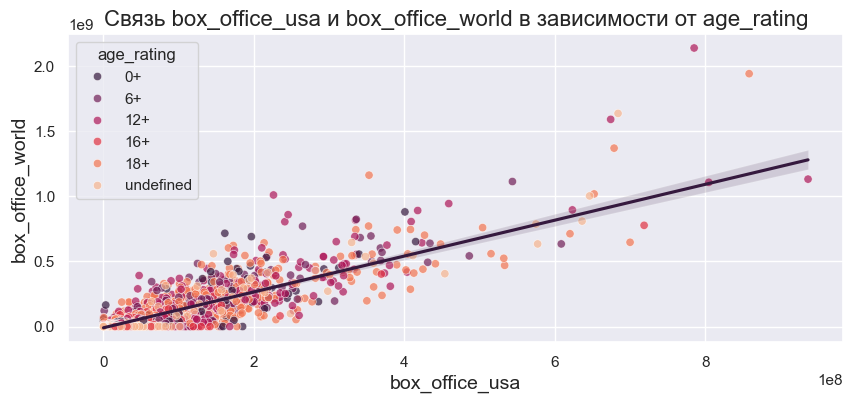

In [79]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.scatterplot(data=df,
                x='box_office_usa',
                y='box_office_world',
                hue='age_rating',
                hue_order=['0+', '6+', '12+', '16+', '18+', 'undefined'],
                alpha=0.7,
                palette='rocket')
sns.regplot(df, x='box_office_usa', y='box_office_world', scatter=False)
ax.set_title(
    'Связь box_office_usa и box_office_world в зависимости от age_rating',
    fontsize=16)
ax.set_xlabel('box_office_usa', fontsize=14)
ax.set_ylabel('box_office_world', fontsize=14);

- действительно, фильмы, который собрали много в мировом прокате, собрали много и в США
- кроме того, если рассматривать еще и возрастной рейтинг, то фильмы 12+ находятся в топе по сборам, но более подробно рассмотрим этот вопрос в одной из следующих гипотез
- гипотеза подтвердилась

## Гипотеза 4

**Возрастной рейтинг влияет на кассовые сборы**

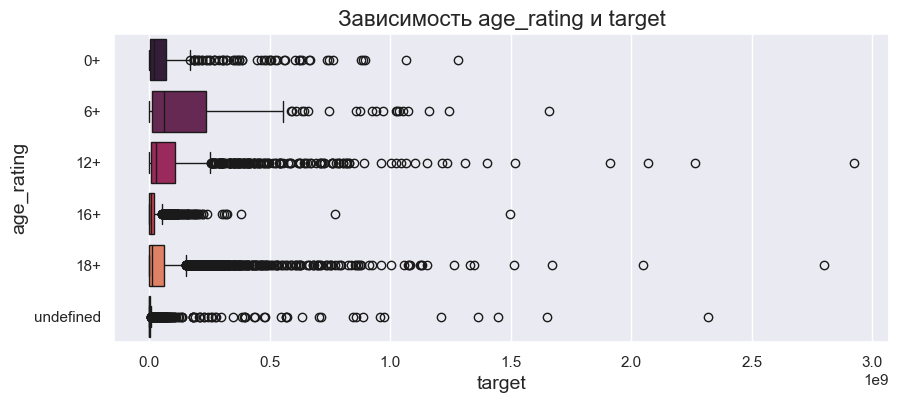

In [80]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(data=df,
            x='target',
            y='age_rating',
            order=['0+', '6+', '12+', '16+', '18+', 'undefined'],
            palette='rocket')
ax.set_title('Зависимость age_rating и target', fontsize=16)
ax.set_xlabel('target', fontsize=14)
ax.set_ylabel('age_rating', fontsize=14);

- можно заметить, что возрастной рейтинг и правда влияет на кассовые сборы 
- в среднем больше денег собирают фильмы с возрастными категориями 0+, 6+ и 12+ 
- как было сказано ранее, это может быть связано с тем, что такие фильмы охватывают более широкую аудиторию и на них могут ходить всей семьей
- гипотеза подвердилась

## Гипотеза 5

**Более известные режиссеры снимают фильмы, которые приносят в среднем больше денег**

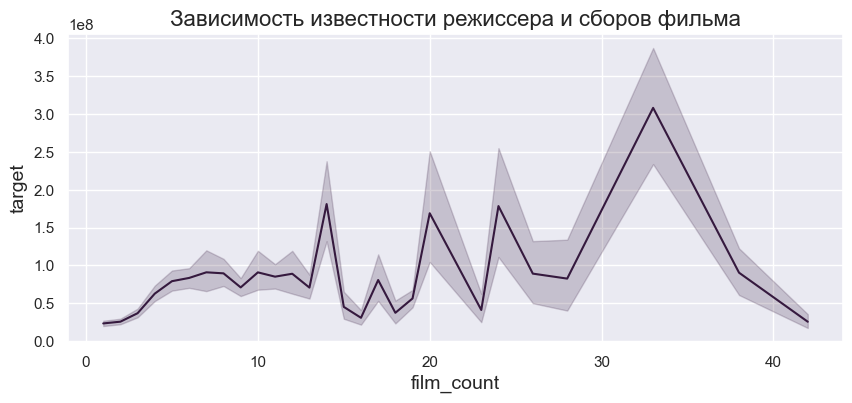

In [81]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=df, x='director_film_count', y='target')
ax.set_title('Зависимость известности режиссера и сборов фильма', fontsize=16)
ax.set_ylabel('target', fontsize=14)
ax.set_xlabel('film_count', fontsize=14);

- если считать, что чем больше фильмов снял режиссер, тем он известнее, то вырисовывается такая картина
- в целом, можно заметить, что режиссеры с большим количеством фильмов снимают фильмы, которые в среднем приносят больше, особенно если сравнивать с режиссерами, у которых по одному фильму
- но если посмотреть на режиссера с наибольшим количеством фильмов, то его фильмы в среднем собрали не так уж и много - примерно на одном уровне с режиссерами, у которых по одному фильму
- хотя несколько предыдущих режиссеров с большим количеством фильмов все же собирали довольно много денег
- гипотеза подтвердилась, если отталкиваться от такого обозначения известности

## Гипотеза 6

**Более новые фильмы приносят больше денег**

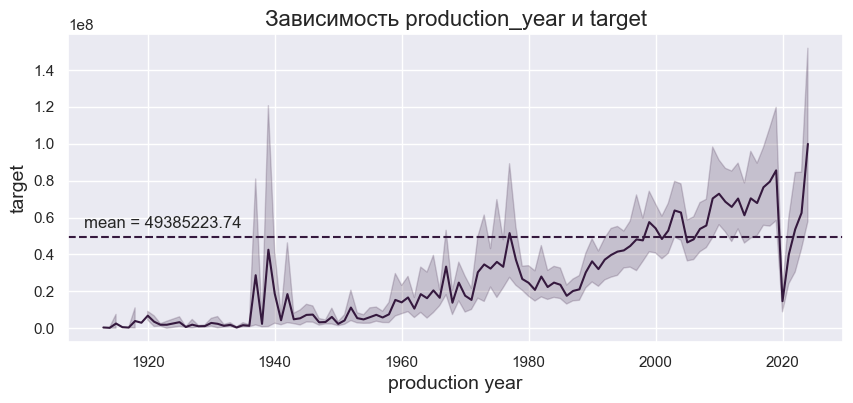

In [82]:
target_mean = df.target.mean()

fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=df, x='production_year', y='target')
plt.axhline(target_mean, linestyle='--')
plt.text(y=target_mean * 1.1, x=1910, s=f'mean = {round(target_mean, 2)}')
ax.set_title('Зависимость production_year и target', fontsize=16)
ax.set_xlabel('production year', fontsize=14)
ax.set_ylabel('target', fontsize=14);

- действительно, обычно чем новее фильм, тем больше денег он принес - фильмы от 1995 года в среднем приносят больше денег, чем срденее значение выручки
- единственный существенный спад был в 2020 - скорее всего, из-за пандемии и карантинов люди все же сидели дома, а не ходили в кино
- гипотеза подтвердилась

## Гипотеза 7

**Наличие известных актеров положительно влияет на сборы**

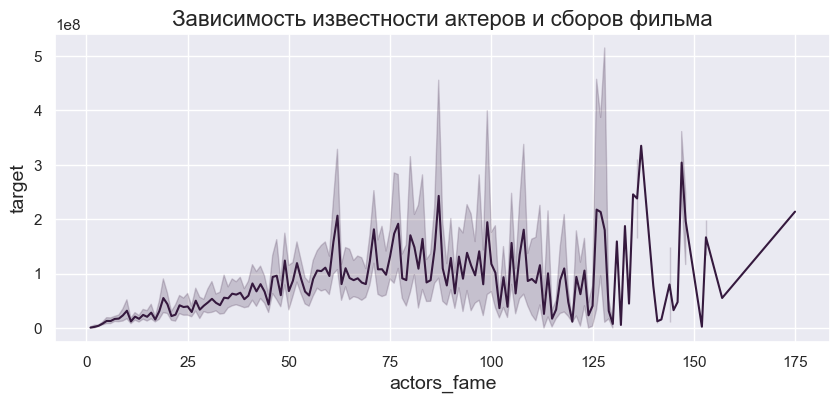

In [83]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=df, x='actors_fame', y='target')
ax.set_title('Зависимость известности актеров и сборов фильма', fontsize=16)
ax.set_ylabel('target', fontsize=14)
ax.set_xlabel('actors_fame', fontsize=14);

- если считать, что известность актеров соответсвует количеству фильмов, в которых они снялись, то можно сделать такие выводы
- как видим, фильмы с более известными актерами и правда в среднем собирают больше денег, чем фильмы с не очень известными актерами 
- но в то же время, чем больше слава, тем больше разброс значений target - фильм может собрать и очень много, и очень мало 
- гипотеза не подствердилась, хоть и некая положительная зависимость есть 

# Преобразование и отбор признаков

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11586 entries, 0 to 49999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   title                11586 non-null  object 
 1   rating               11586 non-null  float64
 2   production_year      11586 non-null  int32  
 3   genre                11586 non-null  object 
 4   director             11586 non-null  object 
 5   age_rating           11586 non-null  object 
 6   release_date         11586 non-null  object 
 7   duration             11586 non-null  int64  
 8   cast                 11586 non-null  object 
 9   budget               11586 non-null  float64
 10  box_office_usa       11586 non-null  float64
 11  box_office_world     11586 non-null  float64
 12  target               11586 non-null  float64
 13  target_log           11586 non-null  float64
 14  main_genre           11586 non-null  object 
 15  month                11586 non-null 

**Сейчас в датафрейме 18 признаков, некоторые из которых будут лишними при построение модели, поэтому удалим их. Кроме того, нужно преобразовать отдельные некоторые значения в столбцах.**

## director

In [85]:
# проверим количество режиссеров
df.director.nunique()

5685

In [86]:
# количество режиссеров, у которых минимум 5 фильмов
(df.director.value_counts() >= 5).sum()

509

- как видим, этот признак имеет довольно много уникальных значений
- кроме того, всего лишь у 509 режиссеров больше, чем 5 фильмов
- поэтому оставим 500 первых режиссеров, а остальные значения заменим на 'Other'

In [87]:
top_directors = df.director.value_counts().nlargest(500).index

# замена остальных значений на 'Other'
df.director = df.director.apply(lambda x: x if x in top_directors else 'Other')

## Удаление признаков

Признаки, которые не нужны для построения модели и которые можно удалить:
- title - название фильма обычно уникальное и никак не влияет на сборы
- release_date - из даты релиза мы получили месяц релиза
- genre - у нас есть признак main_genre, который будет отвечать за основной жанр фильма
- box_office_usa - дублирует таргет переменную
- box_office_world - дублирует таргет переменную
- cast - список актеров будет довольно сложно закодировать (слишком много уникальных значений), поэтому будет использовать вместо этого "известность" актеров

In [88]:
# создание нового датафрейма только с новыми признаками
df_clean = df.drop(config_preproc['drop_columns'], axis=1)

In [89]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11586 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   rating               11586 non-null  float64
 1   production_year      11586 non-null  int32  
 2   director             11586 non-null  object 
 3   age_rating           11586 non-null  object 
 4   duration             11586 non-null  int64  
 5   budget               11586 non-null  float64
 6   target_log           11586 non-null  float64
 7   main_genre           11586 non-null  object 
 8   month                11586 non-null  object 
 9   director_film_count  11586 non-null  int64  
 10  actors_fame          11586 non-null  int64  
dtypes: float64(3), int32(1), int64(3), object(4)
memory usage: 1.0+ MB


In [90]:
def save_unique_values(data: pd.DataFrame, target_column: str,
                       unique_values_path: str) -> None:
    """
    Сохранение уникальных значений признаков
    
    Parameters
    -------------
    data: pd.DataFrame
        дата фрейм с данными
    target_column: str
        название таргет переменной
    unique_values_path: str
        путь к файлу с уникальными значениями
        
    Returns
    --------------
    сохраняет уникальные значения признаков в файл
    """
    df_unique = data.drop(columns=target_column, axis=1)

    dict_unique = {
        key: df_unique[key].unique().tolist()
        for key in df_unique.columns
    }
    
    with open(unique_values_path, "w") as file:
        json.dump(dict_unique, file)

In [91]:
save_unique_values(
    data=df_clean,
    target_column=config_preproc["target_column"],
    unique_values_path=config_preproc["unique_values_path"],
)

## Разделение данных

- разделим данные на train, validation и test в соотношении 64%/16%/20%

In [92]:
# разделение на train и test
train_, test = train_test_split(df_clean,
                                test_size=config_preproc['test_size'],
                                shuffle=True,
                                random_state=RAND)

# разделение на train и validation
train, val = train_test_split(train_,
                              test_size=config_preproc['val_size'],
                              shuffle=True,
                              random_state=RAND)

- сохраним эти данные для дальнейшего использования

In [93]:
train.to_csv(config_preproc['train_data_path'], index=False)
test.to_csv(config_preproc['test_data_path'], index=False)
val.to_csv(config_preproc['val_data_path'], index=False)